In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf

from tensorflow.keras.utils import to_categorical  # correct import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [11]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

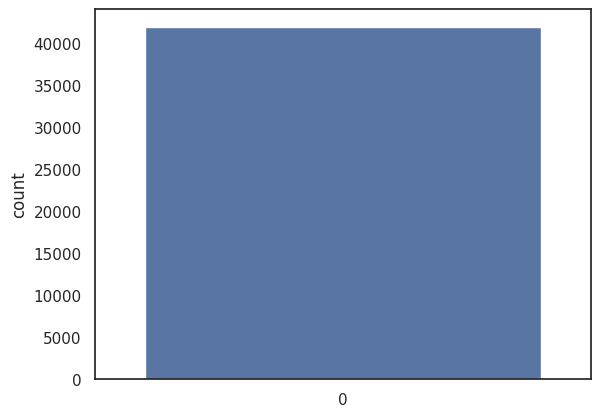

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [12]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis = 1)
del train

g = sns.countplot(Y_train)
plt.show()
Y_train.value_counts()

In [13]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [14]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [15]:
X_train = X_train / 255.0
test = test / 255.0

In [16]:
X_train.shape

(42000, 784)

In [17]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
X_train.shape

(42000, 28, 28, 1)

In [18]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

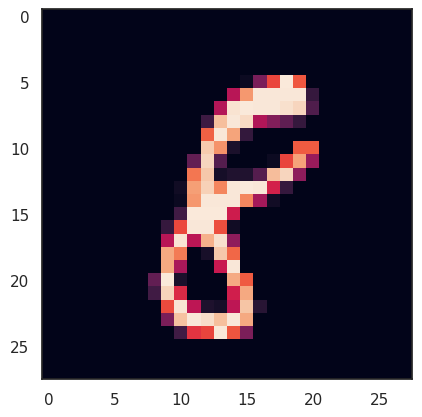

In [19]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)
g = plt.imshow(X_train[0][:,:,0])
g

In [20]:
# CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential([
    Input(shape=(28, 28, 1)), # Block 1
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),# Fully connected layer
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax') # 10 classes for classification
])

In [21]:
from tensorflow.keras.optimizers import RMSprop
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Training parameters
epochs = 10  # You can increase to 30 for better accuracy
batch_size = 86


In [23]:
# # Data Augmentation
# # With data augmentation to prevent overfitting 

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=False,  # randomly flip images
#         vertical_flip=False)  # randomly flip images


# datagen.fit(X_train)

# Fit the model
# history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (X_val,Y_val),
#                               verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
#                               , callbacks=[learning_rate_reduction])

In [25]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
         validation_data = (X_val, Y_val), verbose = 2, callbacks=[tensorboard_callback])

Epoch 1/10
440/440 - 4s - 10ms/step - accuracy: 0.9929 - loss: 0.0227 - val_accuracy: 0.9914 - val_loss: 0.0290
Epoch 2/10
440/440 - 3s - 7ms/step - accuracy: 0.9935 - loss: 0.0214 - val_accuracy: 0.9917 - val_loss: 0.0280
Epoch 3/10
440/440 - 3s - 7ms/step - accuracy: 0.9936 - loss: 0.0217 - val_accuracy: 0.9926 - val_loss: 0.0289
Epoch 4/10
440/440 - 3s - 7ms/step - accuracy: 0.9931 - loss: 0.0223 - val_accuracy: 0.9919 - val_loss: 0.0359
Epoch 5/10
440/440 - 3s - 7ms/step - accuracy: 0.9942 - loss: 0.0207 - val_accuracy: 0.9931 - val_loss: 0.0300
Epoch 6/10
440/440 - 3s - 7ms/step - accuracy: 0.9944 - loss: 0.0196 - val_accuracy: 0.9914 - val_loss: 0.0425
Epoch 7/10
440/440 - 3s - 7ms/step - accuracy: 0.9945 - loss: 0.0200 - val_accuracy: 0.9919 - val_loss: 0.0288
Epoch 8/10
440/440 - 3s - 7ms/step - accuracy: 0.9939 - loss: 0.0200 - val_accuracy: 0.9926 - val_loss: 0.0308
Epoch 9/10
440/440 - 3s - 7ms/step - accuracy: 0.9942 - loss: 0.0196 - val_accuracy: 0.9929 - val_loss: 0.0290


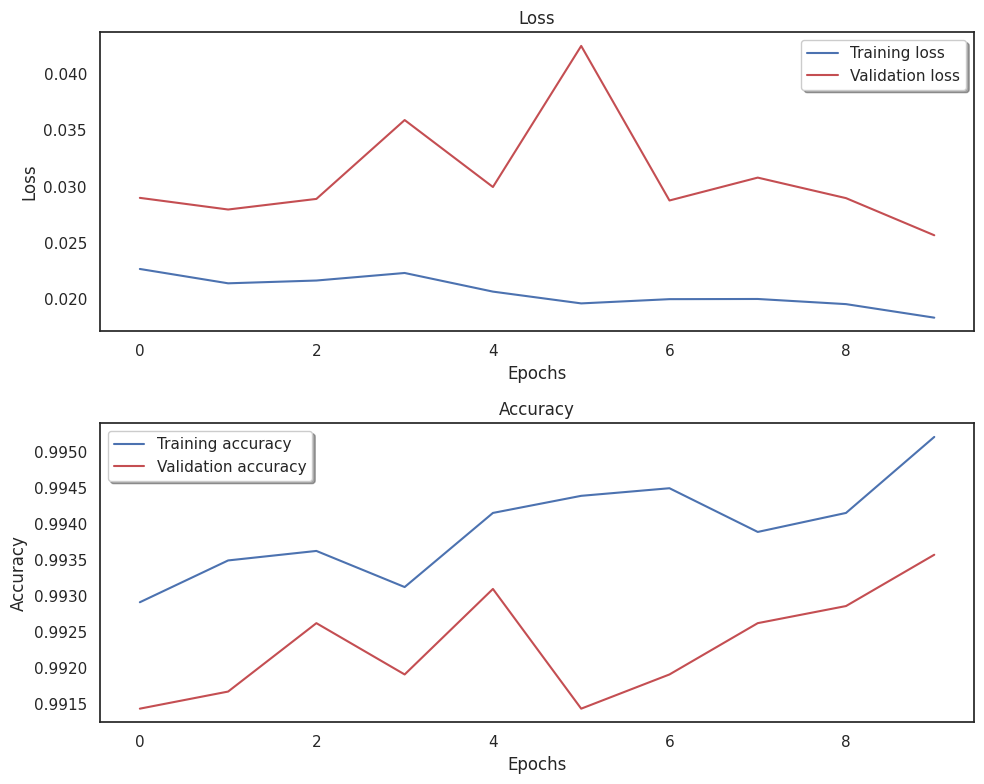

In [27]:
import matplotlib.pyplot as plt

# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot loss
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

# Plot accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()



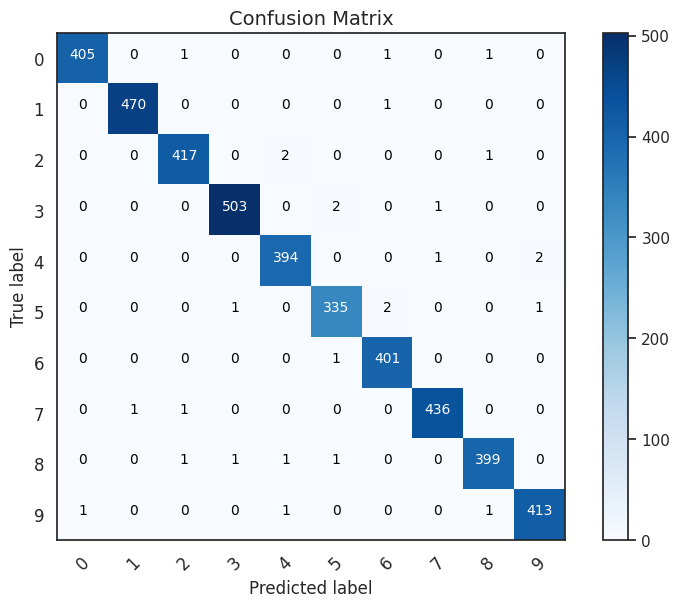

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

# Plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}" if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=10)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()

# ✅ Predict the values from the validation dataset
Y_pred = model.predict(X_val, verbose=0)

# Convert predictions and true labels to class indices
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot it
plot_confusion_matrix(confusion_mtx, classes=range(10), normalize=False)


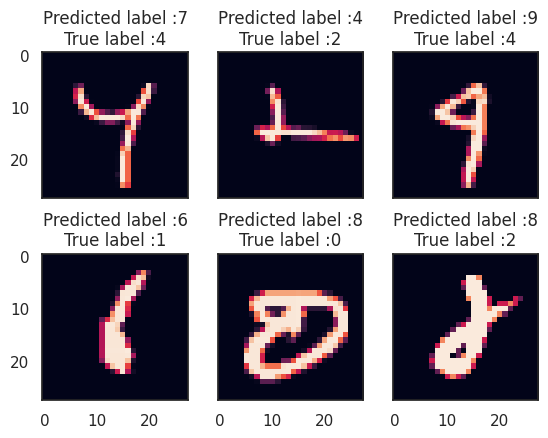

In [29]:


# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)



In [31]:
# # won't work in kaggle
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image
# import numpy as np

# # Create a 28x28 canvas
# fig, ax = plt.subplots()
# ax.set_xlim(0, 28)
# ax.set_ylim(0, 28)
# ax.invert_yaxis()  # Match image coordinates
# ax.set_xticks([])
# ax.set_yticks([])

# # Draw on the canvas (click and drag)
# from matplotlib.widgets import Button
# drawing = False
# x_data, y_data = [], []

# def onclick(event):
#     global drawing, x_data, y_data
#     if event.button == 1:  # Left click
#         drawing = True
#         x_data.append(event.xdata)
#         y_data.append(event.ydata)
#     elif event.button == 3:  # Right click to stop
#         drawing = False
#         plt.close()

# def onmotion(event):
#     global drawing, x_data, y_data
#     if drawing and event.xdata and event.ydata:
#         x_data.append(event.xdata)
#         y_data.append(event.ydata)
#         ax.plot(x_data, y_data, color='black', linewidth=5)
#         fig.canvas.draw()

# fig.canvas.mpl_connect('button_press_event', onclick)
# fig.canvas.mpl_connect('motion_notify_event', onmotion)
# plt.show(block=True)

# # Convert to 28x28 array
# img = np.zeros((28, 28))
# for i in range(len(x_data)-1):
#     x0, y0 = int(x_data[i]), int(y_data[i])
#     x1, y1 = int(x_data[i+1]), int(y_data[i+1])
#     if 0 <= x0 < 28 and 0 <= y0 < 28 and 0 <= x1 < 28 and 0 <= y1 < 28:
#         img[y0:y1+1, x0:x1+1] = 1  # Fill with black (1 for simplicity)
# plt.imshow(img, cmap='gray')
# plt.title('Drawn Digit')
# plt.show()

# # Normalize and reshape
# custom_digit = (1 - img).reshape(1, 28, 28, 1)  # Invert (white=0, black=1) and add channel

# # Load and convert to grayscale
# img = Image.open('your_digit.png').convert('L')  # Replace with your file path
# img = img.resize((28, 28), Image.LANCZOS)  # Resize to 28x28
# img_array = np.array(img) / 255.0  # Normalize to [0, 1]
# custom_digit = img_array.reshape(1, 28, 28, 1)  # Add batch and channel dimensions

# # Predict
# prediction = model.predict(custom_digit)
# predicted_label = np.argmax(prediction, axis=1)[0]
# print(f"Predicted digit: {predicted_label}")
# plt.imshow(custom_digit[0, :, :, 0], cmap='gray')
# plt.title(f'Predicted: {predicted_label}')
# plt.show()

In [32]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")


875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [33]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("cnn_mnist_kaggle.csv",index=False)